Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 81) ---
Variância: 20 features removidas. Restantes: 61
Correlação (>0.95): 22 features redundantes removidas. Restantes: 39
Random Forest: Top 15 selecionadas.
Features Finais (15) - ['Destination Port', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Header Length', 'Fwd Packet Length Max', 'Bwd Packet Length Max', 'Source Port', 'Total Length of Fwd Packets', 'Init_Win_bytes_forward', 'Total Backward Packets', 'Bwd Packet Length Mean', 'Max Packet Length', 'Flow Bytes/s', 'min_seg_size_forward', 'Bwd IAT Total']
--- Fim do Processo de Seleção de Features ---

Normalização: MinMaxScaler
Finalização: Criando objeto NumpySt

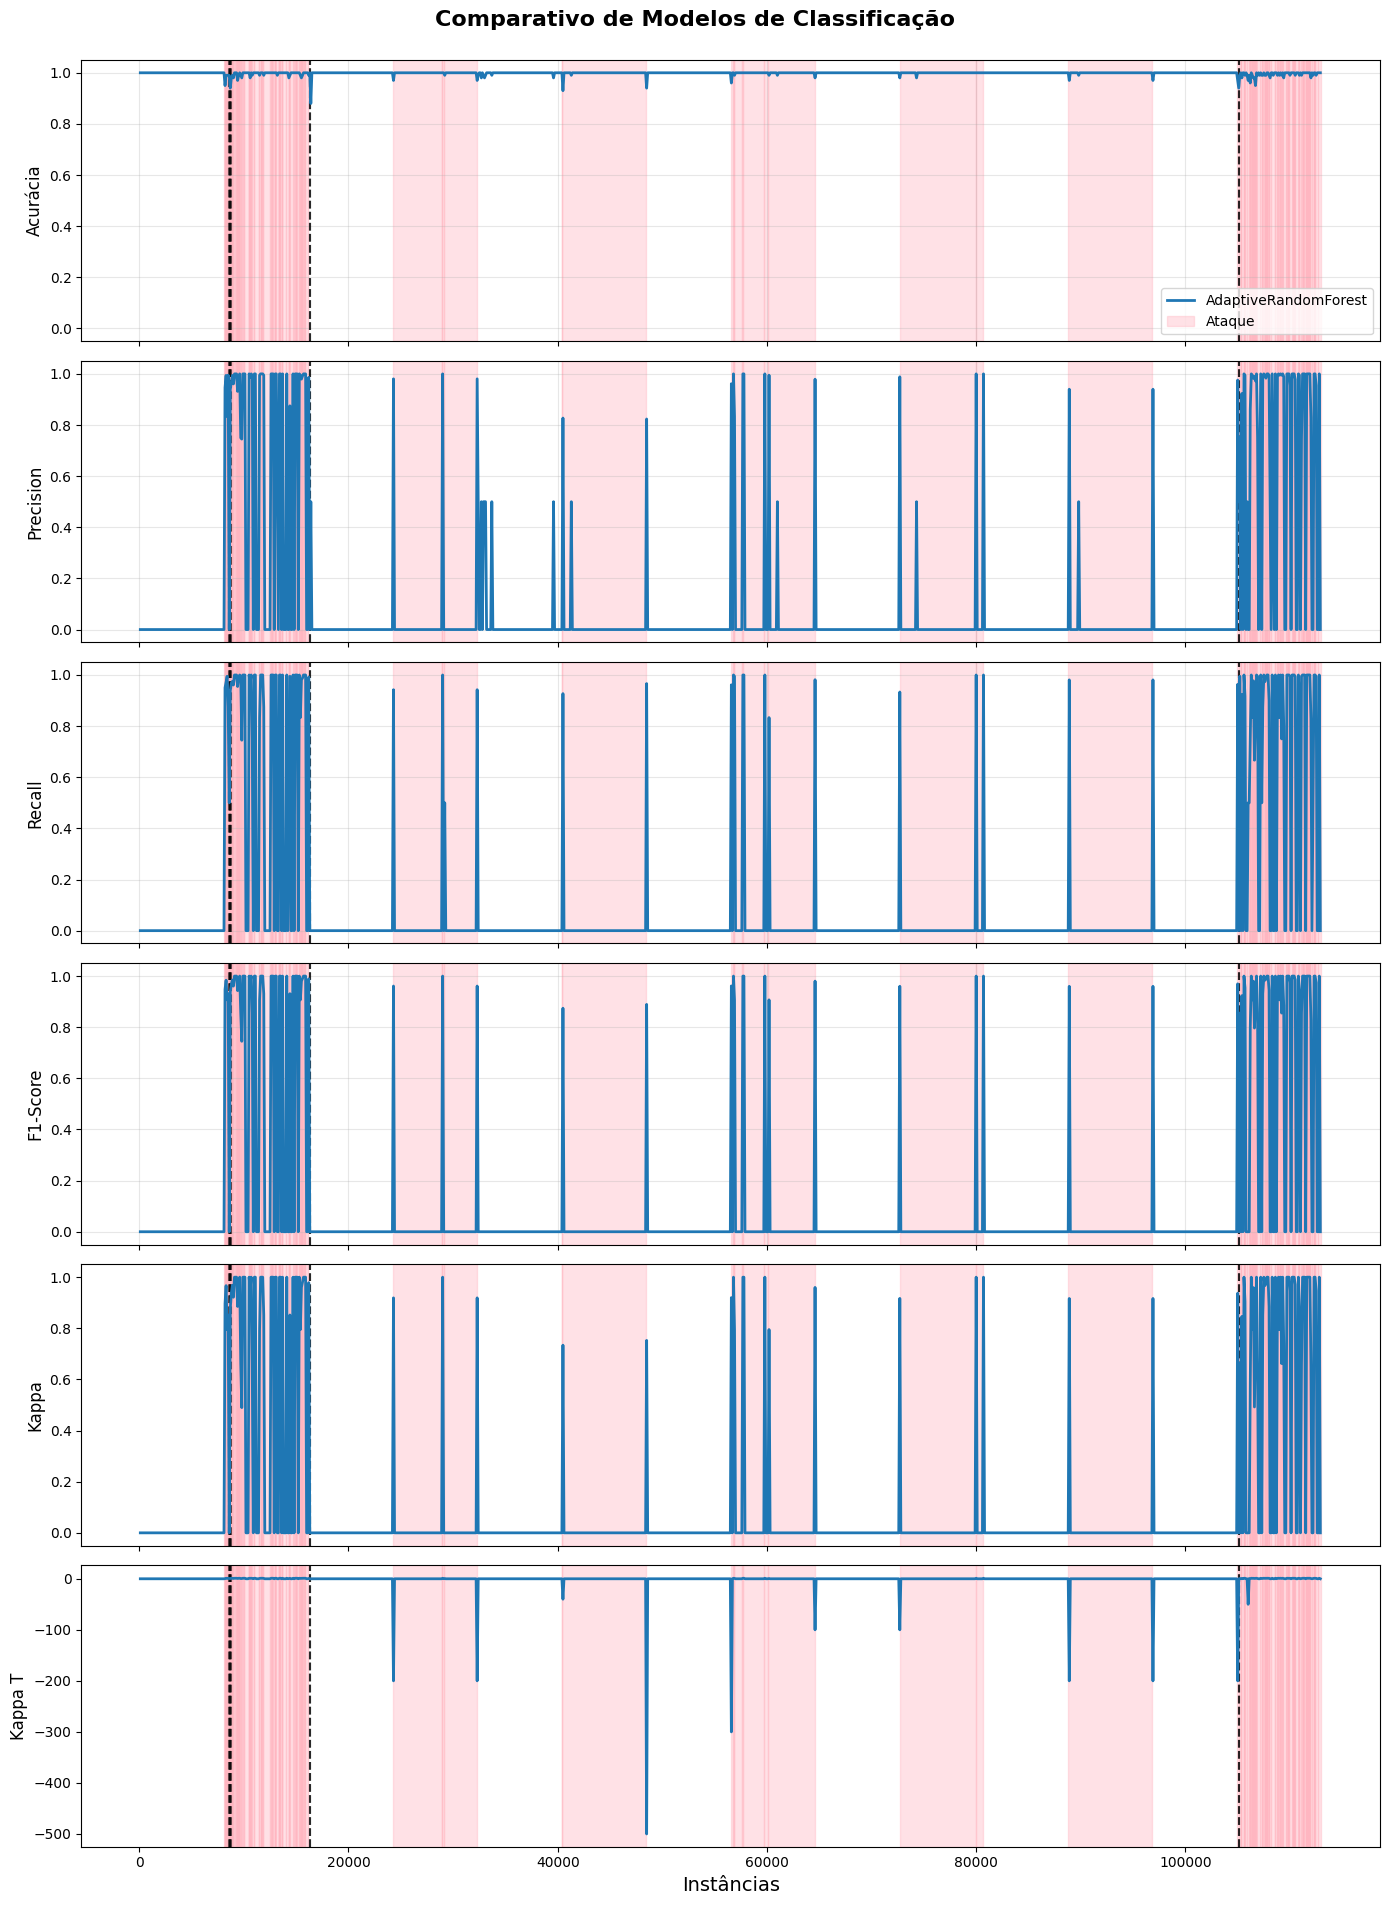

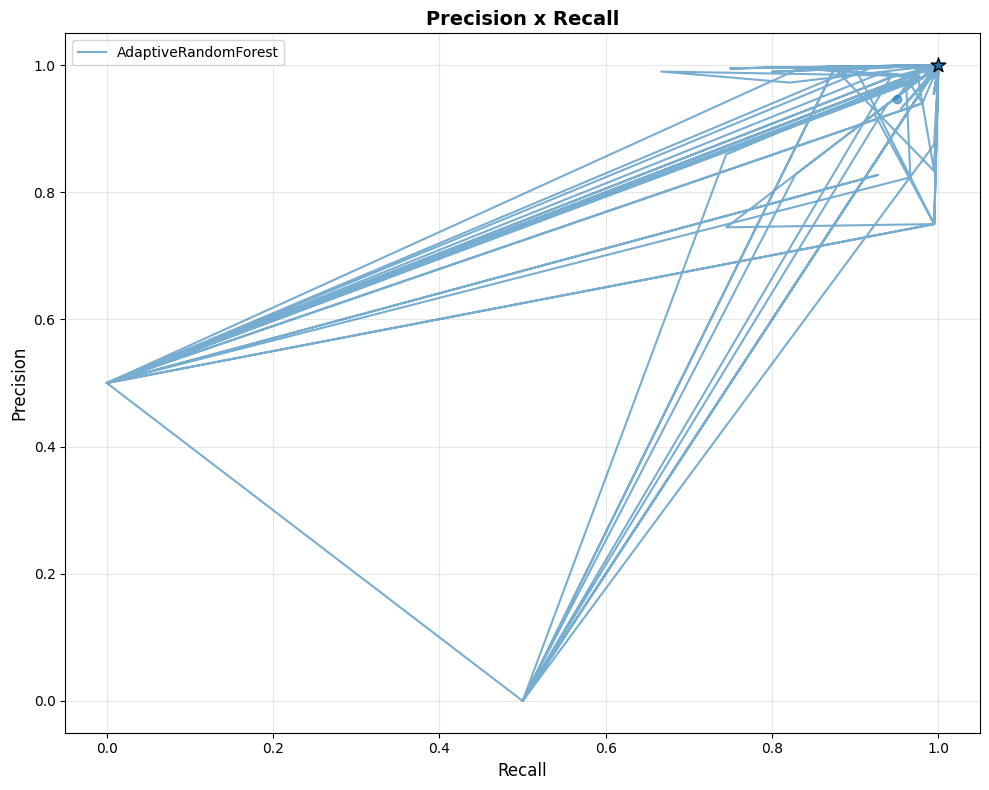

In [6]:
from py.ClassificationModels import get_classification_models
from py.ClassificationPipeline import ClassificationExperimentRunner
from py.streams import newStream
import pandas as pd

INICIO = 0
FIM = 112965
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Multiplos_Ataques.csv',
)

stream, target_names, feature_names = newStream(
    df=df,
    target_label_col='Label',  ## coluna de rótulo
    binary_label=True, # transformar em binário (benigno vs ataque)
    normalize_method="MinMaxScaler", # pode escoler entre "MinMaxScaler" (features entre 0 e 1), "StandardScaler", "RobustScaler" 
    threshold_var=0.75, # variança de cada de coluna # os tres reduz a dimensionalidade do dataset (corta colunas com baixa variância, colunas altamente correlacionadas e seleciona as mais importantes)
    threshold_corr=0.95, # semelhança entre as features
    top_n_features=15, # random forest importance para selecionar as top n features mais importantes entre 15 e 20
    stream=True
) # essa stream é um gerador que vai entregar os dados em tempo real, ou seja, ele vai entregar os dados em blocos, e a cada bloco ele vai atualizar o modelo e calcular as métricas de desempenho.

# Configurar Stream
schema = stream.get_schema()
# schema é o que vai entrar no modelo, ou seja, as colunas do dataset que vão ser usadas para treinar o modelo. Ele é criado a partir do DataFrame original, mas com as colunas selecionadas e normalizadas.

# Obter modelos
modelos = get_classification_models(schema, selected_models=['ARF'], ht_params={}) # seleciona os modelos e os parametros que eu quero.
# quando eu quiser mexer nos parametros do modelo, eu altero nesse get_classification_models

# Instanciar e Executar
runner = ClassificationExperimentRunner()

resultados = runner.pipeline(
    stream=stream,
    models=modelos,
    window_size=100,
    logging=False, ## print de resultados
    title="Comparativo de Modelos de Classificação"
)

Limpeza: Removendo espaços, identificadores (Flow ID, Timestamp, Umma,ed: 0) e colunas vazias...
Pré-processamento: Convertendo infinitos e preenchendo valores nulos...
Target: Processando coluna 'Label' como Binário (0=Normal, 1=Attack)...
Seleção de Features: Iniciando pipeline de redução de dimensionalidade...

--- Iniciando Processo de Seleção de Features (Total: 81) ---
Variância: 20 features removidas. Restantes: 61
Correlação (>0.95): 22 features redundantes removidas. Restantes: 39
Random Forest: Pular.
Features Finais (39) - ['Source Port', 'Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd

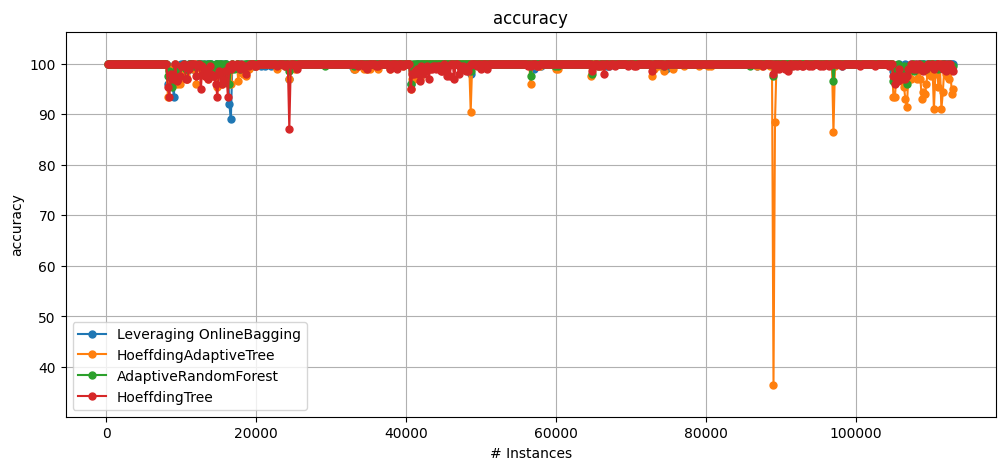

In [5]:
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results
from py.ClassificationModels import get_classification_models
from py.streams import newStream
import pandas as pd

INICIO = 0
FIM = 112965
TOTAL_AMOSTRAS = FIM - INICIO
MAX_INSTANCES = TOTAL_AMOSTRAS

df = pd.read_csv(
    'datasets/CICDDoS2019/data/Multiplos_Ataques.csv',
    skiprows=range(1, INICIO), 
    nrows=TOTAL_AMOSTRAS
)

stream, target_names, feature_names = newStream(
    df=df,
    target_label_col='Label',
    binary_label=True,
    normalize_method="MinMaxScaler",
    threshold_var=0.75,
    threshold_corr=0.95,
    top_n_features=None,
    stream=True
)

# Configurar Stream
schema = stream.get_schema()

# Obter modelos
modelos = get_classification_models(schema, selected_models=['LB', 'HAT', 'ARF', 'HT'])

# Executar avaliação prequential
results = prequential_evaluation_multiple_learners(stream, modelos, window_size=200, max_instances=len(df))

# Exibir resultados
if 'LeveragingBagging' in results:
    print(f"LB accuracy = {results['LeveragingBagging'].cumulative.accuracy()}")

if 'HoeffdingAdaptiveTree' in results:
    print(f"HAT accuracy = {results['HoeffdingAdaptiveTree'].cumulative.accuracy()}")

if 'AdaptiveRandomForest' in results:
    print(f"ARF accuracy = {results['AdaptiveRandomForest'].cumulative.accuracy()}")

if 'HoeffdingTree' in results:
    print(f"HT accuracy = {results['HoeffdingTree'].cumulative.accuracy()}")

plot_windowed_results(*results.values(), metric="accuracy", save_only=False)